# Happy Customers - An Apziva Project

By Samuel Alter

This project centers on a customer survey dataset from a delivery company. The dataset consists of the following:
* `Y`: The target attribute, indicating whether the customer noted their happiness or unhappiness
* `X1`: Order was delivered on time
* `X2`: Contents of the order was as expected (think: after the order has been delivered)
* `X3`: I ordered everything that I wanted to order (think: while placing the order)
* `X4`: I paid a good price for my order
* `X5`: I am satisfied with my courier
* `X6`: The app makes ordering easy for me

Attributes `X1` through `X6` are on a 1 to 5 scale, with 5 indicating most agreement with the statement.

The goals of this project are to train a model that predicts whether a customer is happy or not, based on their answers to the survey. Specifically, I am to reach 73% accuracy or higher with my modeling, or explain why my solution is superior.

A stretch goal would be to determine which features are more important when predicting a customer's happiness. What is the minimal set of attributes or features that would preserve the most information about the problem, while at the same time increasing predictability? The aim here is to see if any question can be eliminated in the next survey round.

The statistical analysis of the features can be found in the [Statistical Modeling](#statistical_modeling) section at the end of this document.

## Table of Contents

1. [EDA](#eda)
> [EDA Summary](#eda_sum)
1. [Initial `lazypredict` model exploration](#lazy_predict)
> This is run in the `lazypredict` environment
> * [Random seed initialization](#rand). This output is saved to a file so that it can be accessed later on in the notebook when using a different environment.
> * [Read in and setup dataset](#read)
> * [Run `LazyClassifier`](#lazy)
1. [Switch to `sklearn` environment](#sklearn)
> The sections involving ML algorithms are run in this environment
1. `XGBoost`
> * [Initial XGBoost model run](#xgboost_initial)
> * [Grid search exploration with the `XGboost` algorithm](#xgboost)
1. [`SGDClassifier`](#sgdc)
> Grid search exploration with the `SGDClassifier` algorithm
> * [`get_dummies`](#sgdc_dummies)
> * [`train_test_split` on OHE'd dataset](#tts_ohe)
> * [Pipeline with `SGDClassifier` and OHE'd data](#pipe_ohe)
> * [Most important features of the OHE'd data](#rfe_ohe)
> * [New pipeline with `SGDClassifier` and categorical (not OHE'd) data](#pipe_notohe)
> * [Most important features of the non-OHE'd data](#rfe_notohe)
> * [Last attempt at pipeline and grid search with thresholded (non-OHE'd) data](#thresholded_grid)
> * [Most important features on the thresholded data](#rfe_threshold)
1. [`hyperopt`](#hyper)
> Our accuracies are still volatile and not ideal, so we will use the `hyperopt` package to help us arrive at better hyperparameters.

## EDA <a name='eda'></a>

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [219]:
df=pd.read_csv('../data/1_data.csv')
df.head(3)

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5


Let's rename the columns to make them more intuitive.

In [220]:
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

# using alphabet prefixes to ensure correct order of columns

In [221]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset")

There are 126 rows and 7 columns in the dataset


In [222]:
df.describe()

,y,a_time,b_contents,c_complete,d_price,e_courier,f_app
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


It seems like most of the participants in the survey were happy about the time it took to receive the order and app experience, but all of this will require more exploration.

In [223]:
df['y'].value_counts()

1    69
0    57
Name: y, dtype: int64

### Figure 1: Distribution of target (Y)

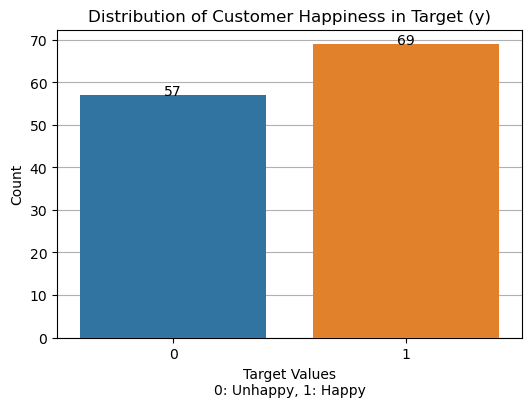

In [224]:
# data labels
x=[0,1]
y=[df['y'].value_counts()[0],df['y'].value_counts()[1]]

plt.figure(figsize=(6, 4))
ax=sns.countplot(data=df, x='y',zorder=3,)
plt.title('Distribution of Customer Happiness in Target (y)')
plt.xlabel('Target Values\n0: Unhappy, 1: Happy')
plt.ylabel('Count')
ax.yaxis.grid(True,zorder=0)
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')
plt.savefig('../figs/1_ydistribution.pdf')
plt.savefig('../figs/1_ydistribution.png')
plt.show()

In [225]:
print(f"In the dataset, {round(df['y'].value_counts()[1]/df['y'].shape[0]*100,2)}% of respondents were happy,\nwhile {round(df['y'].value_counts()[0]/df['y'].shape[0]*100,0)}% of respondents were unhappy.")

In the dataset, 54.76% of respondents were happy,
while 45.0% of respondents were unhappy.


In [226]:
# prepare X data for plotting
col_list=[]

for i in df.columns:
    col_list.append(i)
    
col_list.remove('y')

df_melted=df.melt(value_vars=col_list,var_name='Variable',value_name='Value')

# calculate mean value per variable
mean_values=df_melted.groupby('Variable')['Value'].mean().to_dict()

In [227]:
mean_values

{'a_time': 4.333333333333333,
 'b_contents': 2.5317460317460316,
 'c_complete': 3.3095238095238093,
 'd_price': 3.746031746031746,
 'e_courier': 3.6507936507936507,
 'f_app': 4.253968253968254}

In [228]:
# create custom labels for following figure
labels=[f"{variable}: {mean_values[variable]:.2f}" for variable in mean_values.keys()]
labels

['a_time: 4.33',
 'b_contents: 2.53',
 'c_complete: 3.31',
 'd_price: 3.75',
 'e_courier: 3.65',
 'f_app: 4.25']

In [229]:
df_melted['Variable'].value_counts()

a_time        126
b_contents    126
c_complete    126
d_price       126
e_courier     126
f_app         126
Name: Variable, dtype: int64

In [230]:
xlabs=['Delivery Time',
       'Contents of Order',
       'Order Completeness',
       'Price for Order',
       'Satisfaction with Courier',
       'Satisfaction with App Experience']

### Figure 2: Distribution of survey results

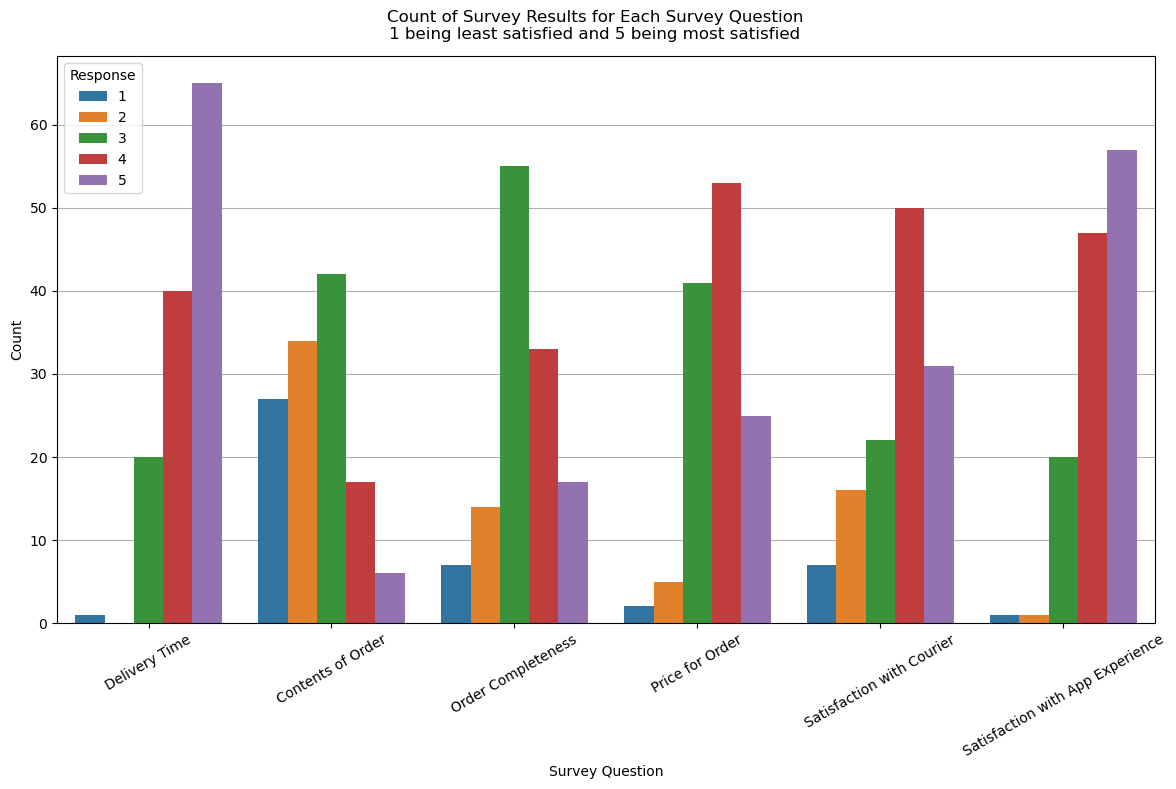

In [231]:
# plot distribution of survey results

plt.figure(figsize=(12,8))
ax=sns.countplot(data=df_melted,x='Variable',hue='Value')
plt.suptitle('Count of Survey Results for Each Survey Question\n1 being least satisfied and 5 being most satisfied')
plt.xlabel('Survey Question')
plt.ylabel('Count')
ax.set_axisbelow(True)
ax.yaxis.grid(True,which='major')
ax.set_xticklabels(xlabs)
plt.xticks(rotation=30)
plt.legend(title='Response',loc='upper left')
plt.tight_layout()
plt.savefig('../figs/1_xdistribution.pdf')
plt.savefig('../figs/1_xdistribution.png')
plt.show()

This plot illustrates well the distribution of responses received in the survey. Although it is harder to draw conclusions from this figure, I think it is still valid to understand the overall trends in the data. Figure 3 has more explanatory value.

In [232]:
# setup labels for mean values
mean_values=df_melted.groupby('Variable')['Value'].mean()
mean_values=mean_values.round(decimals=2)
mean_values

Variable
a_time        4.33
b_contents    2.53
c_complete    3.31
d_price       3.75
e_courier     3.65
f_app         4.25
Name: Value, dtype: float64

In [233]:
# data labels
x=[i for i in np.arange(6)]
y=[mean_values[i] for i in np.arange(6)]

### Figure 3: Mean response to survey question

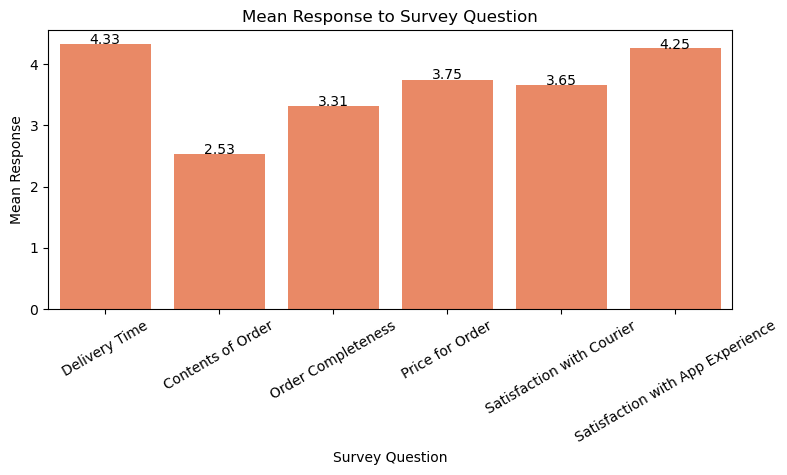

In [234]:
plt.figure(figsize=(10,6))
ax=sns.barplot(data=df_melted,x='Variable',y='Value',ci=None,color='coral')
plt.tight_layout(pad=10)
# plot labels
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha='center')
ax.set_xticklabels(xlabs,rotation=30)
ax.set_title('Mean Response to Survey Question')
ax.set_ylabel('Mean Response')
ax.set_xlabel('Survey Question')
plt.savefig('../figs/1_xmeandistribution.pdf')
plt.savefig('../figs/1_xmeandistribution.png')
plt.show()

The delivery time and app experience had the highest mean satisfaction in the survey, with the contents having the lowest overall.

### Figure 4: Correlation matrix

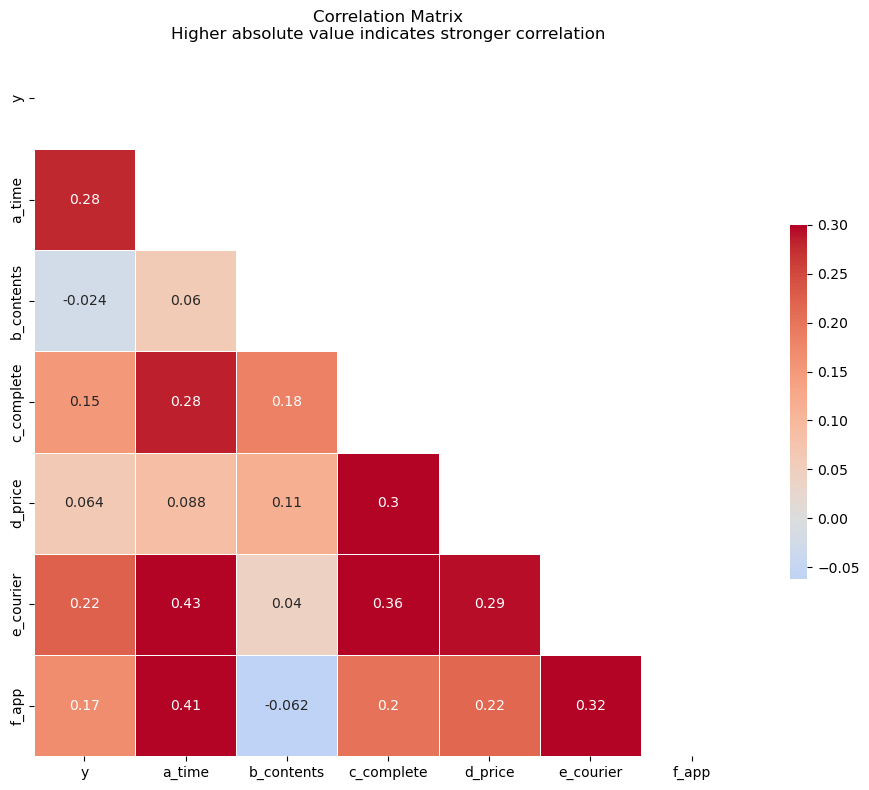

In [38]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": .5})
plt.title('Correlation Matrix\nHigher absolute value indicates stronger correlation')
plt.tight_layout()

# save fig
plt.savefig('../figs/1_corrmatrix.pdf')
plt.savefig('../figs/1_corrmatrix.png')

The results of the correlation matrix show that if one aspect of the experience is positive, the customer will rate others positive as well. One interesting correlation to highlight is the courier and time are connected, which makes sense: the courier is the person that gives you your order, and if the courier is on time you probably will rate the courier highly too.

### EDA Summary <a name='eda_sum'></a>

In the dataset that we were given, roughly half of the respondents were unhappy. From a business standpoint, this is an opportunity to increase the amount of satisfied customers. Hence the survey, ostensibly to understand how the company can improve the satisfaction of their customers.

The results from the survey show that the delivery time and the app experience are places where the company is doing well. Areas for improvement are ensuring that the order is prepared correctly and customers being able to find what they need when they place an order.

We need to do more modeling to understand which survey questions are most important and which can be removed. We will do this in the subsequent sections below.

## Run this section in the `lazypredict` environment <a name='lazy_predict'></a>

[`lazypredict`](#https://lazypredict.readthedocs.io/en/latest/) is a very helpful package that can run through generic builds of a multitude of models in order to get a high-level understanding of the performance of these models on your particular dataset. It is a great place to start and saves a lot of time that would be spent manually exploring the accuracy of different models.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

### Specify random seed <a name='rand'></a>

In [212]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    rng=np.random.default_rng()
    random_state=rng.integers(low=low,high=high)
    return random_state

In [213]:
# define random seed
seed=rand_gen()
seed

1574

In [214]:
# save random seed to file to access it later in the notebook
with open('random_seed.txt','w') as file:
    file.write(str(seed))

In [3]:
# verify that the number got saved
with open('random_seed.txt','r') as file:
    saved_seed=int(file.read())
    print(saved_seed)
    seed=saved_seed

1574


In [33]:
# source:
# https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

# set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
# set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
# set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed)
np.random.default_rng(seed))

SyntaxError: unmatched ')' (4065202940.py, line 13)

### Read in and setup dataset <a name='read'></a>

In [5]:
# read in and setup dataset

df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

# df.dtypes

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary

In [6]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split(X, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=seed)

In [7]:
print(f'''
Shapes of splits:
X_train: {X_train.shape}
X_test:  {X_test.shape}
y_train: {y_train.shape}
y_test:  {y_test.shape}
''')


Shapes of splits:
X_train: (100, 6)
X_test:  (26, 6)
y_train: (100,)
y_test:  (26,)



### Run LazyClassifier <a name='lazy'></a>

In [8]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     random_state=seed)

In [9]:
models, predictions = clf.fit(X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test)

100%|█████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 42.66it/s]

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

Results from the `LazyClassifier`:  <a name='lazy_predict_results'></a>

In [10]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.73,0.73,0.73,0.73,0.17
BernoulliNB,0.73,0.73,0.73,0.73,0.01
SGDClassifier,0.62,0.62,0.62,0.61,0.01
NearestCentroid,0.62,0.62,0.62,0.62,0.01
Perceptron,0.62,0.61,0.61,0.61,0.01
NuSVC,0.58,0.57,0.57,0.58,0.01
GaussianNB,0.58,0.57,0.57,0.57,0.01
CalibratedClassifierCV,0.58,0.55,0.55,0.50,0.02
QuadraticDiscriminantAnalysis,0.54,0.54,0.54,0.54,0.01


In [11]:
models.to_csv('../joblib/1_lazypredict_20240604.csv')

## Switch to `sklearn` environment <a name='sklearn'></a>

In [2]:
import numpy as np
import pandas as pd

In [3]:
models=pd.read_csv('../joblib/1_lazypredict_20240530.csv')

In [4]:
models

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,ExtraTreeClassifier,0.653846,0.636905,0.636905,0.634523,0.003223
1,AdaBoostClassifier,0.615385,0.607143,0.607143,0.610723,0.043834
2,LabelPropagation,0.576923,0.571429,0.571429,0.575020,0.013798
3,LabelSpreading,0.576923,0.571429,0.571429,0.575020,0.003540
4,XGBClassifier,0.576923,0.565476,0.565476,0.567175,0.111497
5,ExtraTreesClassifier,0.576923,0.559524,0.559524,0.553306,0.033341
6,BernoulliNB,0.538462,0.535714,0.535714,0.538462,0.003711
7,RandomForestClassifier,0.538462,0.523810,0.523810,0.521154,0.082804
8,NuSVC,0.538462,0.523810,0.523810,0.521154,0.007902
9,SGDClassifier,0.500000,0.511905,0.511905,0.488756,0.003640


After exploring alternatives, including `LGBMClassifier`, I will now use `XGBoost` instead. In a previous iteration, a previous `random_seed`, it had given me the second-highest accuracy. You'll note that XGBoost is now at a different rank in the model options. This is a lesson that I must always specify a `random_state` to ensure reproducibility.

### Imports

In [5]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [39]:
# open saved random seed from earlier in the notebook
with open('random_seed.txt','r') as file:
    saved_seed=int(file.read())
    print(saved_seed)
    seed=saved_seed

1574


In [7]:
# read in and setup dataset

df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary
                                # let's use less memory
    
X_train, \
X_test, \
y_train, \
y_test = train_test_split(X, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=seed)

print(f'''
Shapes of splits:
X_train: {X_train.shape}
X_test:  {X_test.shape}
y_train: {y_train.shape}
y_test:  {y_test.shape}
''')


Shapes of splits:
X_train: (100, 6)
X_test:  (26, 6)
y_train: (100,)
y_test:  (26,)



### Initial model run <a name='xgboost_initial'></a>

In [40]:
xgbc = XGBClassifier(random_state=seed)
xgbc.fit(X_train, y_train)

y_pred = xgbc.predict(X_test)
print(f'Score on test: {xgbc.score(X_test,y_test)}')
print(classification_report(y_test, y_pred))

Score on test: 0.46153846153846156
              precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.50      0.50      0.50        14

    accuracy                           0.46        26
   macro avg       0.46      0.46      0.46        26
weighted avg       0.46      0.46      0.46        26



The base model is not great yet. Let's keep going forward.

### Grid Search Exploration with `XGBoost`<a name='xgboost'></a>

In [10]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score
import joblib

In [16]:
xgbc = XGBClassifier(random_state=seed)

# commenting this out because it was giving us errors
# as the data is not a categorical dtype

# specifying the k-fold so that we can control the randomness
# statified_k_fold=StratifiedKFold(n_splits=5,
#                                  random_state=random_state,
#                                  shuffle=True)

parameters = {
    'alpha': [0], #(list(np.linspace(0,1,3))),
    'gamma': [0], #(list(np.linspace(0,1,3))),
    'lambda': (list(np.linspace(0.275,0.325,6))),
    'learning_rate': (np.logspace(0.211,0.213,9)),
    'max_depth': [2], #(list(np.arange(1,4))),
    'min_child_weight': (list(np.linspace(3.5,4.5,9))),
    'n_estimators': (np.arange(53,58))
}

# same here - I wanted to control the kfolds
# but it was giving me trouble

# Convert categorical features to one-hot encoded features
# X_train_encoded = pd.get_dummies(X_train)

grid_search = GridSearchCV(xgbc, 
                           parameters, 
                           cv = 5,#statified_k_fold, 
                           n_jobs = -1, 
                           verbose = 0)

# grid_search.fit(X_train_encoded, y_train)
grid_search.fit(X_train, y_train)

# save trained model to pickle file
joblib_file='../joblib/1_gridsearch_xgbc_20240530.pkl'
joblib.dump(grid_search,joblib_file)

['../joblib/1_gridsearch_xgbc_20240530.pkl']

In [17]:
# load grid search file
joblib_file='../joblib/1_gridsearch_xgbc_20240530.pkl'
loaded_grid_search=joblib.load(joblib_file)

In [18]:
# best score
print(f"best score: {loaded_grid_search.best_score_}")

# best parameters 
print(f"best parameters: {loaded_grid_search.best_params_}")

best score: 0.6700000000000002
best parameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.275, 'learning_rate': 1.6302342008295345, 'max_depth': 2, 'min_child_weight': 3.5, 'n_estimators': 53}


List of other best scores from previous `random_seeds` and iterations below:

```python
best score: 0.64
best parameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.275, 'learning_rate': 1.625548755750484, 'max_depth': 2, 'min_child_weight': 4.375, 'n_estimators': 53}
```

```python
best score: 0.6900000000000001
best parameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.3, 'learning_rate': 1.6292960326397223, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 55}
```

```python
best score: 0.68
best parameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.275, 'learning_rate': 1.6330519478943344, 'max_depth': 2, 'min_child_weight': 3.875, 'n_estimators': 56}
```

Let's now confirm results with running the best parameters again. I will use a pipeline as I want to ensure that I can include a `random_state` and make sure that the model understands that we're dealing with categorical data.

In [20]:
from sklearn.pipeline import Pipeline

# X columns are categorical so they need to be OHE'd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold

In [21]:
# setup classifier
model=XGBClassifier(alpha=0,
                    gamma=0,
                    reg_lambda=0.3,
                    learning_rate=1.6292960326397223,
                    max_depth=2,
                    min_child_weight=4,
                    n_estimators=55,
                    random_state=seed)

# preprocessor to handle categorical features, make them OHE'd
# it will ignore any categories that are not found in X_test
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), [0, 1])
    ])

# create pipeline
pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('xgb',model)
])

# allow for five cross-validation folds
stratified_k_fold=StratifiedKFold(n_splits=5,
                                 random_state=seed,
                                 shuffle=True)

# perform cross-validation and print accuracy
scores=cross_val_score(pipeline, 
                       X, 
                       y, 
                       cv=stratified_k_fold, 
                       scoring='accuracy')

print('Cross-validated accuracy: '\
f'{scores.mean()*100:.2f}% ± {scores.std()*100:.2f}%')

Cross-validated accuracy: 57.88% ± 8.47%


I'm satisfied with that. It's close enough. It's great to see that we were able to increase the accuracy from <50% to >50%. It's still not a great accuracy level, but much better.

### `SGDClassifier` <a name='sgdc'></a>

Per the past results from the `lazypredict` [here](#lazy_predict_results), I will switch to the `SGDClassifier`. I will also employ a more in-depth pipeline to include other steps, like `RFE`, for feature elimination. This gets at the stretch goal of the company who gave us the dataset.

We should `get_dummies` on our dataset and run a correlation matrix because I'm curious. With the dataset transformed to be OneHotEncoded, rather than staying categorical, would different correlations jump out at us? Let's see.

#### `get_dummies`<a name='sgdc_dummies'></a>

In [9]:
# read in and setup dataset again

df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary
                                # let's use less memory

print("X shape:",X.shape)
print("y shape:",y.shape)

X shape: (126, 6)
y shape: (126,)


In [10]:
X.dtypes

a_time        int64
b_contents    int64
c_complete    int64
d_price       int64
e_courier     int64
f_app         int64
dtype: object

`pd.get_dummies` requires the data be categorical:

In [11]:
X_cat=X.copy()

for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype('category')
    
X_cat.dtypes

a_time        category
b_contents    category
c_complete    category
d_price       category
e_courier     category
f_app         category
dtype: object

In [12]:
X_ohe=pd.get_dummies(data=X_cat,
                     prefix=list(X_cat.columns),
                     drop_first=False) # I want to 
                                       # see all survey responses
                                       # that are in dataset

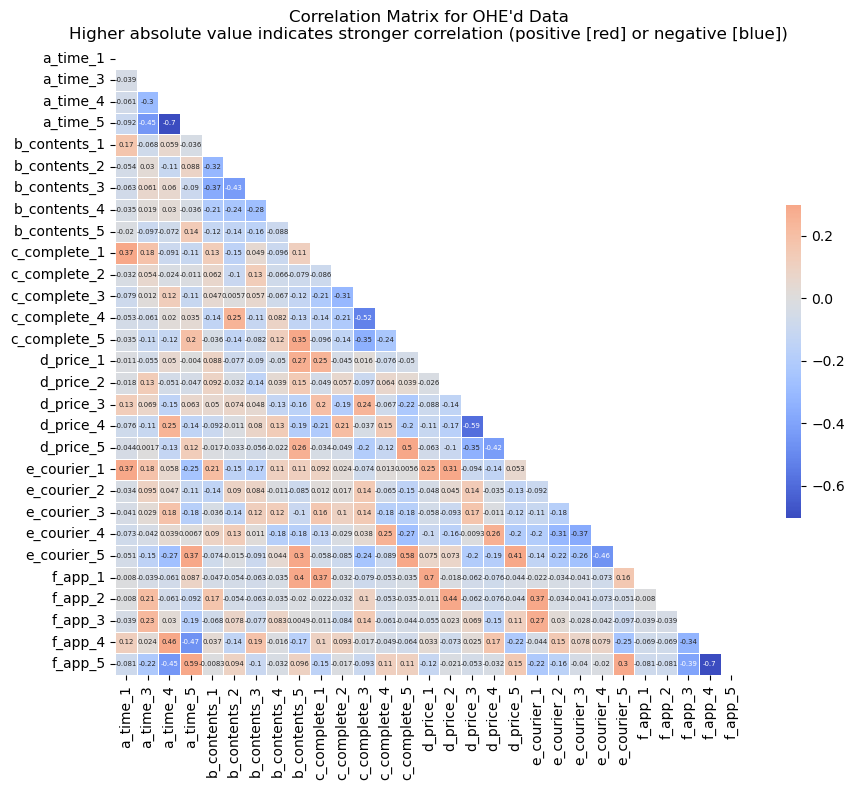

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr = X_ohe.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": .5},
            annot_kws={"size":5})
plt.title("Correlation Matrix for OHE'd Data\nHigher absolute value indicates stronger correlation (positive [red] or negative [blue])")
plt.tight_layout()

# save fig
plt.savefig('../figs/1_corrmatrix_ohe.pdf')
plt.savefig('../figs/1_corrmatrix_ohe.png')

Nothing much to learn here except that if a specific category scored high, other categories likely scored high. This is also true if categories scored low. Some categories are missing as there is no data recorded for them. For example, no respondent scored `time` as a `2`.

I'm curious why, for example, people that scored the `app` as `4` were not likely to score the `time` as `5`. This may be explained later in our modeling and statistical analysis.

#### `train_test_split` on the OHE'd dataset <a name='tts_ohe'></a>

In [14]:
# train/test split
X_train_ohe, \
X_test_ohe, \
y_train_ohe, \
y_test_ohe = train_test_split(X_ohe, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=seed)

In [15]:
# confirm that the split occurred
print(f'''
Shapes of splits:
X_train: {X_train_ohe.shape}
X_test:  {X_test_ohe.shape}
y_train: {y_train_ohe.shape}
y_test:  {y_test_ohe.shape}
''')


Shapes of splits:
X_train: (100, 29)
X_test:  (26, 29)
y_train: (100,)
y_test:  (26,)



In [17]:
X_train_ohe.sample(3)

,a_time_1,a_time_3,a_time_4,a_time_5,b_contents_1,b_contents_2,b_contents_3,b_contents_4,b_contents_5,c_complete_1,...,e_courier_1,e_courier_2,e_courier_3,e_courier_4,e_courier_5,f_app_1,f_app_2,f_app_3,f_app_4,f_app_5
94,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
28,0,1,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
24,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


Great, now we're ready for a new pipeline with `SGDClassifier`.

#### New Pipeline with `SGDClassifier` and OneHotEncoded X data <a name='pipe_ohe'></a>

##### More notes on the Pipeline choices:

* `RFE` is great for feature selection, as it can help you understand which features are most important. RFE requires a base estimator to assign weights to features. We can use a logistic regression model.
* We're using the `SGDClassifier` as the final step in our pipeline as it scored the top accuracy in our `lazypredict` run.
* We'll set up a grid search so that we can explore the hyperparameter space to find the best hyperparameters for our dataset.

In [30]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [31]:
# specifying the k-fold so that we can control the randomness

stratified_k_fold=StratifiedKFold(n_splits=5,
                                 random_state=seed,
                                 shuffle=True)

estimators=[
    ('rfe',RFE(estimator=LogisticRegression(random_state=seed))),
    ('sgd',SGDClassifier(random_state=seed))]

pipeline = Pipeline(estimators)

param_grid = [
    {
        'rfe__n_features_to_select': list(np.arange(1, 7)),
        'rfe__importance_getter': ['feature_importances_','auto'],
        'sgd__max_iter': list(np.logspace(2, 5, 4).astype('int')),
        'sgd__alpha': list(np.logspace(-5, -1, 5)),
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd__learning_rate': ['optimal'],
        'rfe__estimator': [LogisticRegression(random_state=seed)],
        'rfe__importance_getter': ['auto']
    },
    {
        'rfe__n_features_to_select': list(np.arange(1, 7)),
        'sgd__max_iter': list(np.logspace(2, 5, 4).astype('int')),
        'sgd__alpha': list(np.logspace(-5, -1, 5)),
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd__learning_rate': ['optimal'],
        'rfe__estimator': [RandomForestClassifier(random_state=seed)],
        'rfe__importance_getter': ['auto']
    }
]

# perform grid search with cross-validation
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=stratified_k_fold,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train_ohe, y_train_ohe)

# save trained model to pickle file
joblib_file='../joblib/1_gridsearch_rfe_sgd_20240530.pkl'
joblib.dump(grid_search,joblib_file)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


['../joblib/1_gridsearch_rfe_sgd_20240530.pkl']

In [32]:
# load grid search file
joblib_file='../joblib/1_gridsearch_rfe_sgd_20240530.pkl'
loaded_grid_search=joblib.load(joblib_file)

In [33]:
# best score
print(f"best score: {loaded_grid_search.best_score_}")

# best parameters 
print(f"best parameters: {loaded_grid_search.best_params_}")

best score: 0.6599999999999999
best parameters: {'rfe__estimator': RandomForestClassifier(random_state=36791776), 'rfe__importance_getter': 'auto', 'rfe__n_features_to_select': 5, 'sgd__alpha': 0.01, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'modified_huber', 'sgd__max_iter': 100, 'sgd__penalty': 'l1'}


In [34]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [35]:
# Make predictions on the test set using the best model
y_pred_ohe = loaded_grid_search.best_estimator_.predict(X_test_ohe)

# Calculate and print the evaluation metrics
metrics = {
    'accuracy': accuracy_score(y_test_ohe, y_pred_ohe),
    'precision': precision_score(y_test_ohe, y_pred_ohe),
    'recall': recall_score(y_test_ohe, y_pred_ohe),
    'f1': f1_score(y_test_ohe, y_pred_ohe)
}

print("Test Accuracy:", metrics['accuracy'])
print("Precision:    ", metrics['precision'])
print("Recall:       ", metrics['recall'])
print("F1 Score:     ", metrics['f1'])

Test Accuracy: 0.38461538461538464
Precision:     0.375
Recall:        0.21428571428571427
F1 Score:      0.2727272727272727


This result is quite terrible.

Confirm that the accuracy percentage is based on `X_test` and not `X_train` - so if we run the cell below, we should get the same accuracy from the grid search:

In [36]:
y_pred_ohe = loaded_grid_search.best_estimator_.predict(X_train_ohe)

# Calculate and print the evaluation metrics
metrics = {
    'accuracy': accuracy_score(y_train_ohe, y_pred_ohe),
    'precision': precision_score(y_train_ohe, y_pred_ohe),
    'recall': recall_score(y_train_ohe, y_pred_ohe),
    'f1': f1_score(y_train_ohe, y_pred_ohe)
}

print("Test Accuracy:", metrics['accuracy'])
print("Precision:    ", metrics['precision'])
print("Recall:       ", metrics['recall'])
print("F1 Score:     ", metrics['f1'])

Test Accuracy: 0.64
Precision:     0.7435897435897436
Recall:        0.5272727272727272
F1 Score:      0.6170212765957446


##### Extracting the most important features from the dataset: <a name='rfe_ohe'></a>

In [37]:
# get best estimator from grid search
best_estimator=loaded_grid_search.best_estimator_

# access RFE transformer within pipeline
rfe=best_estimator.named_steps['rfe']

# get selected features
selected_features_indices=rfe.support_

# extract names of selected features
selected_features=X_train_ohe.columns[selected_features_indices]

print(f"The top features that are most important:\n{selected_features}")

# obtain ranking of features
feature_ranking=rfe.ranking_

# feature names
feature_names=X_train_ohe.columns

# create dataframe to store feature names and rankings
feature_ranking_df=pd.DataFrame({'Feature': feature_names,
                                 'Ranking': feature_ranking})

feature_ranking_df=feature_ranking_df.sort_values(by='Ranking')

# arbitrary subset of the entire df
# (the entire df includes all columns and their importance rank)
# feature_ranking_df
feature_ranking_df.head(5)

The top features that are most important:
Index(['a_time_5', 'c_complete_4', 'd_price_4', 'e_courier_5', 'f_app_4'], dtype='object')


,Feature,Ranking
12,c_complete_4,1
3,a_time_5,1
17,d_price_4,1
27,f_app_4,1
23,e_courier_5,1


This is really great to see, that the `RFE` was able to pull out what it thinks are the most important features. It is not as informative for a human, as these features are a binary representation of categorical data. Let's try running the non-binary version of the dataset through the trained model. Maybe we'll get more informative results?

In [44]:
feature_ranking_df

,Feature,Ranking
12,c_complete_4,1
3,a_time_5,1
17,d_price_4,1
27,f_app_4,1
23,e_courier_5,1
6,b_contents_3,2
11,c_complete_3,3
2,a_time_4,4
21,e_courier_3,5
4,b_contents_1,6


In [53]:
# save feature rankings
feature_ranking_df.to_csv('../data/1_feature_ranking_df_20240530.csv')

#### New pipeline with `SGDClassifier` and categorical (not OHE'd) X data <a name='pipe_notohe'></a>

##### Redefine X data without OneHotEncodings:

In [20]:
# read in and setup dataset again

df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary
                                # let's use less memory

print("X shape:",X.shape)
print("y shape:",y.shape)

X shape: (126, 6)
y shape: (126,)


In [21]:
X.dtypes

a_time        int64
b_contents    int64
c_complete    int64
d_price       int64
e_courier     int64
f_app         int64
dtype: object

In [22]:
X_cat=X.copy()

for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype('category')
    
X_cat.dtypes

a_time        category
b_contents    category
c_complete    category
d_price       category
e_courier     category
f_app         category
dtype: object

In [23]:
# train/test split
X_train_cat, \
X_test_cat, \
y_train_cat, \
y_test_cat = train_test_split(X_cat, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=seed)

In [24]:
X_train_cat.shape

(100, 6)

In [25]:
X_train_cat.head(3)

,a_time,b_contents,c_complete,d_price,e_courier,f_app
74,5,2,5,5,5,5
121,5,2,3,4,4,3
65,4,1,3,4,4,4


In [54]:
# specifying the k-fold so that we can control the randomness
stratified_k_fold=StratifiedKFold(n_splits=5,
                                 random_state=seed,
                                 shuffle=True)

estimators=[
    ('rfe',RFE(estimator=LogisticRegression(random_state=seed))),
    ('sgd',SGDClassifier(random_state=seed))]

pipeline = Pipeline(estimators)

param_grid = [
    {
        'rfe__n_features_to_select': list(np.arange(1, 7)),
        'rfe__importance_getter': ['feature_importances_','auto'],
        'sgd__max_iter': list(np.logspace(2, 5, 4).astype('int')),
        'sgd__alpha': list(np.logspace(-5, -1, 5)),
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd__learning_rate': ['optimal'],
        'rfe__estimator': [LogisticRegression(random_state=seed)],
        'rfe__importance_getter': ['auto']
    },
    {
        'rfe__n_features_to_select': list(np.arange(1, 7)),
        'sgd__max_iter': list(np.logspace(2, 5, 4).astype('int')),
        'sgd__alpha': list(np.logspace(-5, -1, 5)),
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd__learning_rate': ['optimal'],
        'rfe__estimator': [RandomForestClassifier(random_state=seed)],
        'rfe__importance_getter': ['auto']
    }
]

# perform grid search with cross-validation
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=stratified_k_fold,
                           verbose=1,
                           n_jobs=-1)

# note that this is now on the categorical
# X_train and y_train, not OHE'd data
grid_search.fit(X_train_cat, y_train_cat)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=79056830, shuffle=True),
             estimator=Pipeline(steps=[('rfe',
                                        RFE(estimator=LogisticRegression(random_state=79056830))),
                                       ('sgd',
                                        SGDClassifier(random_state=79056830))]),
             n_jobs=-1,
             param_grid=[{'rfe__estimator': [LogisticRegression(random_state=79056830)],
                          'rfe__importance_getter': ['auto'],
                          'rfe__n_feature...
                         {'rfe__estimator': [RandomForestClassifier(random_state=79056830)],
                          'rfe__importance_getter': ['auto'],
                          'rfe__n_features_to_select': [1, 2, 3, 4, 5, 6],
                          'sgd__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                          'sgd__learning_rate': ['optimal'],
                          'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
                          'sgd__max_iter': [100, 1000, 10000, 100000],
                          'sgd__penalty': ['l2', 'l1', 'elasticnet']}],
             verbose=1)

In [55]:
# save trained model to pickle file
# but first, get unique datetime tag 
# to differentiate pickle files
from datetime import datetime

# get current date and time
current_datetime=datetime.now()

# print current date and time to check
print(current_datetime)

# format the datetime for a filename
datetime_suffix=current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# create filename with the datetime suffix
joblib_file=f'../joblib/1_gridsearch_rfe_sgd_{datetime_suffix}.pkl'

# save model
joblib.dump(grid_search,joblib_file)

2024-05-31 08:45:12.632571


['../joblib/1_gridsearch_rfe_sgd_2024-05-31_08-45-12.pkl']

In [56]:
# load model
joblib_file=f'../joblib/1_gridsearch_rfe_sgd_{datetime_suffix}.pkl'
loaded_grid_search=joblib.load(joblib_file)

In [57]:
# best score
print(f"best score: {loaded_grid_search.best_score_}")

# best parameters 
print(f"best parameters: {loaded_grid_search.best_params_}")

best score: 0.67
best parameters: {'rfe__estimator': LogisticRegression(random_state=79056830), 'rfe__importance_getter': 'auto', 'rfe__n_features_to_select': 3, 'sgd__alpha': 0.1, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'hinge', 'sgd__max_iter': 100, 'sgd__penalty': 'elasticnet'}


In [58]:
# Make predictions on the test set using the best model
y_pred_cat = loaded_grid_search.best_estimator_.predict(X_test_cat)

# Calculate and print the evaluation metrics
metrics = {
    'accuracy': accuracy_score(y_test_cat, y_pred_cat),
    'precision': precision_score(y_test_cat, y_pred_cat),
    'recall': recall_score(y_test_cat, y_pred_cat),
    'f1': f1_score(y_test_cat, y_pred_cat)
}

print("Test Accuracy:", metrics['accuracy'])
print("Precision:    ", metrics['precision'])
print("Recall:       ", metrics['recall'])
print("F1 Score:     ", metrics['f1'])

Test Accuracy: 0.5769230769230769
Precision:     0.5714285714285714
Recall:        0.8571428571428571
F1 Score:      0.6857142857142857


Not a great accuracy result.

##### Extracting the most important features from the dataset: <a name='rfe_notohe'></a>

In [62]:
# get best estimator from grid search
best_estimator=loaded_grid_search.best_estimator_

# access RFE transformer within pipeline
rfe=best_estimator.named_steps['rfe']

# get selected features
selected_features_indices=rfe.support_

# extract names of selected features
selected_features=X_train_cat.columns[selected_features_indices]

print(f"The top features that are most important:\n{selected_features}")

# obtain ranking of features
feature_ranking=rfe.ranking_

# feature names
feature_names=X_train_cat.columns

# create dataframe datetime_suffixture names and rankings
feature_ranking_df_cat=pd.DataFrame({'Feature': feature_names,
                                 'Ranking': feature_ranking})

feature_ranking_df_cat=feature_ranking_df_cat.sort_values(by='Ranking')

feature_ranking_df_cat

The top features that are most important:
Index(['a_time', 'b_contents', 'e_courier'], dtype='object')


,Feature,Ranking
0,a_time,1
1,b_contents,1
4,e_courier,1
5,f_app,2
2,c_complete,3
3,d_price,4


In [61]:
# save feature rankings
feature_ranking_df_cat.to_csv('../data/1_feature_ranking_df_cat_20240531.csv')

This feature ranking is a lot easier to understand. Here, we can see that time, contents, and the performance of the courier are most important for this iteration of the model. Interestingly, price is not an important predictor.

#### Final pipeline/grid search with thresholded data <a name='thresholded_grid'></a>

In [26]:
# define thresholding function
# if the person scored a category as a 4 or 5,
# we give a value of 1. Otherwise, we give it a 0
threshold_func = lambda x: 1 if x >= 4 else 0

# apply the function to the dataframe
X_threshold = X.applymap(threshold_func)
X_threshold.head(3)

,a_time,b_contents,c_complete,d_price,e_courier,f_app
0,0,0,0,1,0,1
1,0,0,0,1,1,0
2,1,0,0,0,0,1


In [28]:
# train/test split
X_train_threshold, \
X_test_threshold, \
y_train_threshold, \
y_test_threshold = train_test_split(X_threshold, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=seed)

In [29]:
X_train_threshold.shape

(100, 6)

In [30]:
X_train_threshold.head(3)

,a_time,b_contents,c_complete,d_price,e_courier,f_app
74,1,0,1,1,1,1
121,1,0,0,1,1,0
65,1,0,0,1,1,1


In [87]:
# specifying the k-fold so that we can control the randomness
stratified_k_fold=StratifiedKFold(n_splits=5,
                                 random_state=seed,
                                 shuffle=True)

estimators=[
    ('rfe',RFE(estimator=LogisticRegression(random_state=seed))),
    ('sgd',SGDClassifier(random_state=seed))]

pipeline = Pipeline(estimators)

param_grid = [
    {
        'rfe__n_features_to_select': list(np.arange(1, 7)),
        'rfe__importance_getter': ['feature_importances_','auto'],
        'sgd__max_iter': list(np.logspace(2, 5, 4).astype('int')),
        'sgd__alpha': list(np.logspace(-5, -1, 5)),
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd__learning_rate': ['optimal'],
        'rfe__estimator': [LogisticRegression(random_state=seed)],
        'rfe__importance_getter': ['auto']
    },
    {
        'rfe__n_features_to_select': list(np.arange(1, 7)),
        'sgd__max_iter': list(np.logspace(2, 5, 4).astype('int')),
        'sgd__alpha': list(np.logspace(-5, -1, 5)),
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd__learning_rate': ['optimal'],
        'rfe__estimator': [RandomForestClassifier(random_state=seed)],
        'rfe__importance_getter': ['auto']
    }
]

# perform grid search with cross-validation
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=stratified_k_fold,
                           verbose=1,
                           n_jobs=-1)


# X_train and y_train on thresholded data
grid_search.fit(X_train_threshold, y_train_threshold)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=79056830, shuffle=True),
             estimator=Pipeline(steps=[('rfe',
                                        RFE(estimator=LogisticRegression(random_state=79056830))),
                                       ('sgd',
                                        SGDClassifier(random_state=79056830))]),
             n_jobs=-1,
             param_grid=[{'rfe__estimator': [LogisticRegression(random_state=79056830)],
                          'rfe__importance_getter': ['auto'],
                          'rfe__n_feature...
                         {'rfe__estimator': [RandomForestClassifier(random_state=79056830)],
                          'rfe__importance_getter': ['auto'],
                          'rfe__n_features_to_select': [1, 2, 3, 4, 5, 6],
                          'sgd__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                          'sgd__learning_rate': ['optimal'],
                          'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
                          'sgd__max_iter': [100, 1000, 10000, 100000],
                          'sgd__penalty': ['l2', 'l1', 'elasticnet']}],
             verbose=1)

In [88]:
# save trained model to pickle file
# but first, get unique datetime tag 
# to differentiate pickle files
from datetime import datetime

# get current date and time
current_datetime=datetime.now()

# print current date and time to check
print(current_datetime)

# format the datetime for a filename
datetime_suffix=current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# create filename with the datetime suffix
joblib_file=f'../joblib/1_gridsearch_rfe_sgd_threshold_{datetime_suffix}.pkl'

# save model
joblib.dump(grid_search,joblib_file)

2024-05-31 09:42:23.082348


['../joblib/1_gridsearch_rfe_sgd_threshold_2024-05-31_09-42-23.pkl']

In [89]:
# load model
joblib_file=f'../joblib/1_gridsearch_rfe_sgd_threshold_{datetime_suffix}.pkl'
loaded_grid_search=joblib.load(joblib_file)

In [90]:
# best score
print(f"best score: {loaded_grid_search.best_score_}")

# best parameters 
print(f"best parameters: {loaded_grid_search.best_params_}")

best score: 0.65
best parameters: {'rfe__estimator': RandomForestClassifier(random_state=79056830), 'rfe__importance_getter': 'auto', 'rfe__n_features_to_select': 2, 'sgd__alpha': 0.01, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log_loss', 'sgd__max_iter': 100, 'sgd__penalty': 'l2'}


In [91]:
# Make predictions on the test set using the best model
y_pred_threshold = loaded_grid_search.best_estimator_.predict(X_test_threshold)

# Calculate and print the evaluation metrics
metrics = {
    'accuracy': accuracy_score(y_test_threshold, y_pred_threshold),
    'precision': precision_score(y_test_threshold, y_pred_threshold),
    'recall': recall_score(y_test_threshold, y_pred_threshold),
    'f1': f1_score(y_test_threshold, y_pred_threshold)
}

print("Test Accuracy:", metrics['accuracy'])
print("Precision:    ", metrics['precision'])
print("Recall:       ", metrics['recall'])
print("F1 Score:     ", metrics['f1'])

Test Accuracy: 0.46153846153846156
Precision:     0.5
Recall:        0.5
F1 Score:      0.5


Still a pretty dismal accuracy result.

##### Extracting the most important features from the dataset: <a name='rfe_threshold'></a>

In [92]:
# get best estimator from grid search
best_estimator=loaded_grid_search.best_estimator_

# access RFE transformer within pipeline
rfe=best_estimator.named_steps['rfe']

# get selected features
selected_features_indices=rfe.support_

# extract names of selected features
selected_features=X_train_cat.columns[selected_features_indices]

print(f"The top features that are most important:\n{selected_features}")

# obtain ranking of features
feature_ranking=rfe.ranking_

# feature names
feature_names=X_train_cat.columns

# create dataframe datetime_suffixture names and rankings
feature_ranking_df_threshold=pd.DataFrame({'Feature': feature_names,
                                 'Ranking': feature_ranking})

feature_ranking_df_threshold=feature_ranking_df_cat.sort_values(by='Ranking')

feature_ranking_df_threshold

The top features that are most important:
Index(['a_time', 'e_courier'], dtype='object')


,Feature,Ranking
0,a_time,1
1,b_contents,1
4,e_courier,1
5,f_app,2
2,c_complete,3
3,d_price,4


In [93]:
# save feature rankings
feature_ranking_df_threshold.to_csv('../data/1_feature_ranking_df_threshold_20240531.csv')

This is a promising result, in that the same features are being shown as important here as well as in previous iterations of the pipeline above. `time`, `contents`, and `courier` are equally important, while `app`, `complete`, and `price` are less important.

Our accuracies are not consistent, so we will shift to using the `hyperopt` package to help us arrive at more optimal hyperparameters.

### `hyperopt` <a name='hyper'></a>

Tutorial is [here](#http://hyperopt.github.io/hyperopt/tutorials/01.BasicTutorial/) and [here](#https://towardsdev.com/optimizing-hyperparameters-with-hyperopt-a-hands-on-tutorial-2839efcbc177?gi=de88b6cfe1cd).  
And I'm following examples from [here](#https://github.com/hyperopt/hyperopt-sklearn) and [here](#https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce).

In [8]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split

In [9]:
# access random seed
with open('random_seed.txt','r') as file:
    saved_seed=int(file.read())
    print(saved_seed)
    seed=saved_seed

1574


In [10]:
# source:
# https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

# set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
# set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
# set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed)

In [11]:
# read in and setup dataset again

df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary
                                # let's use less memory

print("X shape:",X.shape)
print("y shape:",y.shape)

# define thresholding function
# if the person scored a category as a 4 or 5,
# we give a value of 1. Otherwise, we give it a 0
threshold_func = lambda x: 1 if x >= 4 else 0

# apply the function to the dataframe
X_threshold = X.applymap(threshold_func)
X_threshold

# train/test split
X_train_threshold, \
X_test_threshold, \
y_train_threshold, \
y_test_threshold = train_test_split(X_threshold, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=seed)

X shape: (126, 6)
y shape: (126,)


In [12]:
X_threshold.head(3)

,a_time,b_contents,c_complete,d_price,e_courier,f_app
0,0,0,0,1,0,1
1,0,0,0,1,1,0
2,1,0,0,0,0,1


#### Notes on `hyperopt` parameters

* Using `RFE` to select which features are most important
* `ExtraTreeClassifier` is used as the final model as it gave good results from the `LazyPredict`

In [27]:
test=float(seed)
type(test)
test

1574.0

In [35]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0

    def hyperopt_train_test(self, params):
        # Extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type
        if t == 'extratrees':
            clf = ExtraTreesClassifier(**params)
        else:
            return 0
        
        # define RFE with the classifier
        rfe = RFE(estimator=clf, 
                  n_features_to_select=n_features_to_select)
        
        # perform cross-validation
        return cross_val_score(rfe, self.X, self.y).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print('new best:', acc, 'using', params['type'])
            self.best = acc
        if self.count % 25 == 0:
            print('iters:', self.count, ', acc:', acc, 'using', params)
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space = hp.choice('classifier_type', [
    {
        'type': 'extratrees',
        'n_features_to_select': hp.choice('n_features_to_select', 
                                          range(1, X.shape[1]+1)),
        'n_estimators': hp.choice('n_estimators', range(10, 100)),
        'max_depth': hp.choice('max_depth', range(1, 20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"])
    }
])

# instantiate optimizer
optimizer = HyperoptOptimizer(X_threshold, y)

# initialize trials object
trials = Trials()

rstate = np.random.default_rng(seed)

# run optimization
best = fmin(optimizer.objective, 
            space, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials,
            rstate=rstate,
            return_argmin=False)
print('best:')
print(best)

new best:                                                                                     
0.484                                                                                         
using                                                                                         
extratrees                                                                                    
new best:                                                                                     
0.5076923076923077                                                                            
using                                                                                         
extratrees                                                                                    
new best:                                                                                     
0.5636923076923076                                                                            
using                                             

In [36]:
trials.best_trial

{'state': 2,
 'tid': 30,
 'spec': None,
 'result': {'loss': -0.604, 'status': 'ok'},
 'misc': {'tid': 30,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'classifier_type': [30],
   'criterion': [30],
   'max_depth': [30],
   'n_estimators': [30],
   'n_features_to_select': [30]},
  'vals': {'classifier_type': [0],
   'criterion': [0],
   'max_depth': [0],
   'n_estimators': [24],
   'n_features_to_select': [2]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 6, 6, 14, 46, 55, 788000),
 'refresh_time': datetime.datetime(2024, 6, 6, 14, 46, 56, 167000)}

In [39]:
best

{'criterion': 'gini',
 'max_depth': 1,
 'n_estimators': 34,
 'n_features_to_select': 3,
 'type': 'extratrees'}

In [38]:
# Retrieve the best hyperparameters found
# optimal_params = {k: v for k, v in best.items() if k in space}

Save the best parameters:

In [125]:
import json

with open('../joblib/1_hyperopt_bestparams_20240603.json','w') as file:
    file.write(json.dumps(best,default=str))

In [126]:
# extract best parameters
best_params=trials.best_trial

In [133]:
import datetime

In [134]:
def myconverter(obj):
# source: https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, datetime.datetime):
            return obj.__str__()

In [135]:
with open('../joblib/1_hyperopt_bestparams_20240604.json','w') as file:
    file.write(json.dumps(best_params,default=myconverter))

In [146]:
best_params['misc']['idxs']['n_features_to_select']

[1042]

In [155]:
best_model = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['params']
worst_model = trials.results[np.argmax([r['loss'] for r in 
    trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in 
    trials.results])]['params']

KeyError: 'model'

Run the best parameters on the dataset:

In [139]:
import json
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [190]:
# load best parameters from JSON file
with open('../joblib/1_hyperopt_bestparams_20240604.json', 'r') as f:
    best_params = json.load(f)

# extract best parameters
best_n_features_to_select = best_params['n_features_to_select']
del best_params['n_features_to_select']
best_type = best_params['type']
del best_params['type']

# train final model using best parameters
if best_type == 'extratrees':
    final_clf = ExtraTreesClassifier(**best_params, random_state=42)
    
# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train, y_train)

# evaluate final model on test set
final_score = final_rfe.score(X_test, y_test)
print('Final test score:', final_score)

KeyError: 'n_features_to_select'

Next attempt is adapted from tutorial from [MachineLearningMastery.com](#https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/):

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe

# define search
model = HyperoptEstimator(regressor=any_regressor('reg'), 
                          preprocessing=any_preprocessing('pre'), 
                          loss_fn=mean_absolute_error, 
                          algo=tpe.suggest, 
                          max_evals=50, 
                          trial_timeout=30,
                          seed=seed)
# perform the search
model.fit(X_train_threshold, y_train_threshold,random_state=seed)
# summarize performance
mae = model.score(X_test_threshold, y_test_threshold)
print("MAE: %.3f" % mae)
# summarize the best model
print(model.best_model())

  0%|                                                   | 0/1 [00:00<?, ?trial/s, best loss=?]


AttributeError: 'numpy.random.mtrand.RandomState' object has no attribute 'integers'

### Statistical Modeling with `Statsmodels` <a name="statistical_modeling"></a>

In [33]:
import statsmodels.api as sm

In [34]:
# read in and setup dataset again

df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary
                                # let's use less memory

# print("X shape:",X.shape)
# print("y shape:",y.shape)

# print(X.dtypes)

X_cat=X.copy()

for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype('category')
    
# X_cat.dtypes

X_ohe=pd.get_dummies(data=X_cat,
                     prefix=list(X_cat.columns),
                     drop_first=False) # I think we need to 
                                       # see all survey responses
                                       # that are in dataset

In [35]:
# add constant to our X
X_const=sm.add_constant(X_ohe[[col for col in X_ohe.columns if col != 'y']])

In [36]:
# check it out
X_const.head(3)

,const,a_time_1,a_time_3,a_time_4,a_time_5,b_contents_1,b_contents_2,b_contents_3,b_contents_4,b_contents_5,...,e_courier_1,e_courier_2,e_courier_3,e_courier_4,e_courier_5,f_app_1,f_app_2,f_app_3,f_app_4,f_app_5
0,1.0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1.0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1.0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [234]:
X_const.dtypes

Series([], dtype: object)

In [229]:
y.shape

(126,)

In [231]:
# instantiate the logistic regression model 
logreg = sm.Logit(y, X_const)

# fit the model
logreg_results = logreg.fit()

# display the results 
logreg_results.summary()

ValueError: zero-size array to reduction operation maximum which has no identity

PLACEHOLDER TEXT  
All features have p-values above 0.05 except time, which is just under the limit.

In [209]:
# getting the model predictions as probabilities 
# and saving to 'y_proba'
y_proba = logreg_results.predict(X_const)

# view 
y_proba

NameError: name 'logreg_results' is not defined

In [210]:
# assume probability >=50%
# is a happy customer prediction
# so we'll make the soft preds into hard preds
y_pred = np.where(y_proba >= 0.5, 1, 0)

# look at the model's predictions
y_pred

NameError: name 'y_proba' is not defined

In [211]:
# calculate accuracy
# find where predicted = true survival
# then divide by the number of predictions/passengers
acc = (y_pred == y).sum()/df.shape[0]

# Print the accuracy score
print(f'Model accuracy = {acc}')

ValueError: ('Lengths must match to compare', (126,), (26,))

In [212]:
# put params into a dataframe
results_df = pd.DataFrame(logreg_results.params, columns=['Coefficient'])

# view the dataframe
results_df

NameError: name 'logreg_results' is not defined

In [213]:
# calculate and add the odds ratios to results_df
# log odds is more interpretable
results_df['odds_ratio'] = np.exp(results_df['Coefficient'])

# display the dataframe
results_df

NameError: name 'results_df' is not defined

Each component of the survey shows that it has an impact on the overall happiness of the customer. Time is the largest factor, which makes sense: when you're hungry, you want food as soon as possible.

Given that the p-values of time was the only factor that was below the 0.05 threshold suggests that we should try this again with only time as the independent variable.

In [214]:
# add constant to our X
X_const=sm.add_constant(df[[col for col in df.columns if col != 'y']])

In [215]:
# check it out
X_const=X_const.drop([col for col in X_const.columns if (col !='a_time') or (col !='const')],axis=1)
X_const

""
0
1
2
3
4
...
121
122
123
124


In [216]:
# instantiate the logistic regression model 
logreg = sm.Logit(y, X_const)

# fit the model
logreg_results = logreg.fit()

# display the results 
logreg_results.summary()

ValueError: zero-size array to reduction operation maximum which has no identity

In [217]:
# getting the model predictions as probabilities 
# and saving to 'y_proba'
y_proba = logreg_results.predict(X_const)

# view 
y_proba

NameError: name 'logreg_results' is not defined

In [218]:
# assume probability >=50%
# is a happy customer prediction
# so we'll make the soft preds into hard preds
y_pred = np.where(y_proba >= 0.5, 1, 0)

# look at the model's predictions
y_pred

NameError: name 'y_proba' is not defined

In [219]:
# calculate accuracy
# find where predicted = true survival
# then divide by the number of predictions/passengers
acc = (y_pred == y).sum()/df.shape[0]

# Print the accuracy score
print(f'Model accuracy = {acc}')

ValueError: ('Lengths must match to compare', (126,), (26,))

In [220]:
# put params into a dataframe
results_df = pd.DataFrame(logreg_results.params, columns=['Coefficient'])

# view the dataframe
results_df

NameError: name 'logreg_results' is not defined

In [221]:
# calculate and add the odds ratios to results_df
# log odds is more interpretable
results_df['odds_ratio'] = np.exp(results_df['Coefficient'])

# display the dataframe
results_df

NameError: name 'results_df' is not defined

Oops, that did not work!

Apziva: UP2IqAzAWrVBrULk